# Временные ряды

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy.stats as st

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.holtwinters import ExponentialSmoothing


## Warmup

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/andriygav/PSAD/master/seminars/sem9/data/time.txt', parse_dates=[0], dayfirst=True)

In [5]:
data.head()

,Time
0,10.02.2019
1,10.02.2019
2,12.02.2019
3,12.02.2019
4,13.02.2019


In [6]:
groups = data['Time'].groupby(data['Time']).count()

In [7]:
data = groups.cumsum()

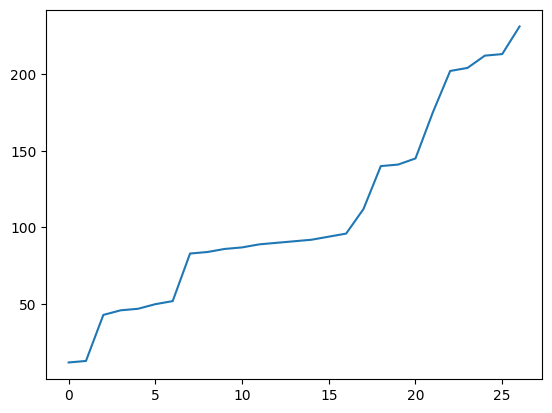

In [8]:
_ = plt.plot(data.values)
plt.show()

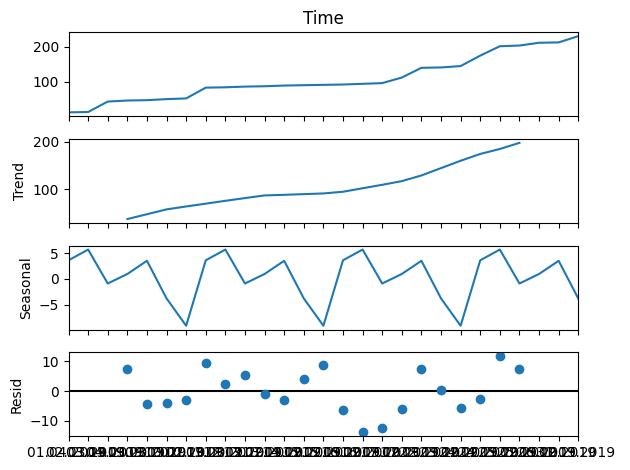

In [9]:
stl_data = seasonal_decompose(data, period=7)
_= stl_data.plot()
plt.show()

### ARIMA

In [10]:
kpss(data, nlags='legacy')

(0.42685160702371727,
 0.06558120386908739,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [69]:
new_data = {}
time_iter = pd.date_range('20190210','20190401',freq='D')
old_data = None
for i in time_iter:
    key = '.'.join(str(i).split(' ')[0].split('-')[::-1])
    if key in data:
        new_data[i] = float(data[key])
        old_data = new_data[i]
    elif key+' ' in data:
        new_data[i] = float(data[key+' '])
        old_data = new_data[i]
    else:
        new_data[i] = old_data

new_data = pd.DataFrame({'Time':new_data})

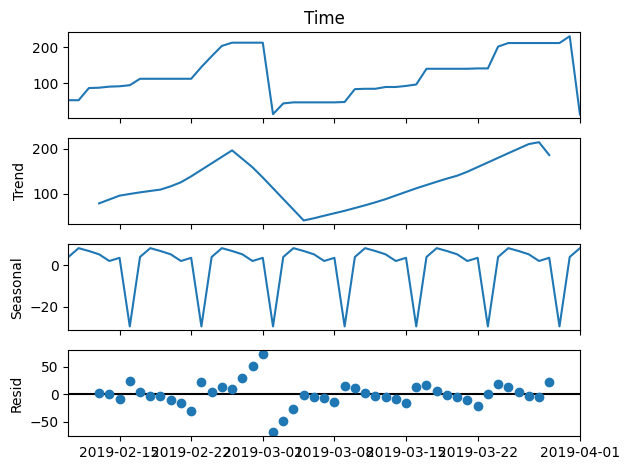

In [55]:
stl_data = seasonal_decompose(new_data['Time'], period=7)
stl_data.plot()

plt.show()

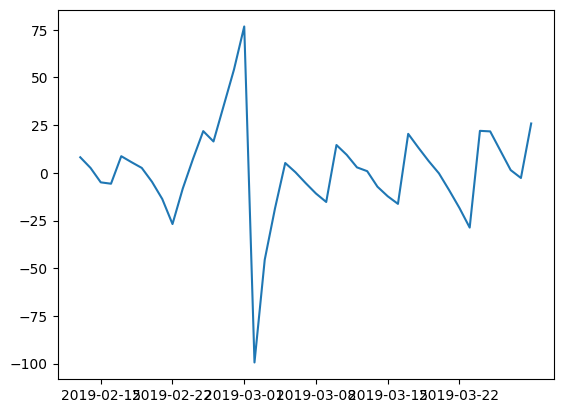

In [57]:
new_data_without_trend = new_data.copy()[3:-3]
new_data_without_trend['Time'] = (new_data['Time'] - stl_data.trend)[3:-3]
plt.plot(new_data_without_trend)

plt.show()

In [58]:
kpss(new_data['Time'], nlags='legacy')

<ipython-input-58-09b3aa849245>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(new_data['Time'], nlags='legacy')


(0.2058735366446952,
 0.1,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [59]:
kpss(new_data_without_trend['Time'], nlags='legacy')

<ipython-input-59-74668682c92c>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(new_data_without_trend['Time'], nlags='legacy')


(0.13383963397103987,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

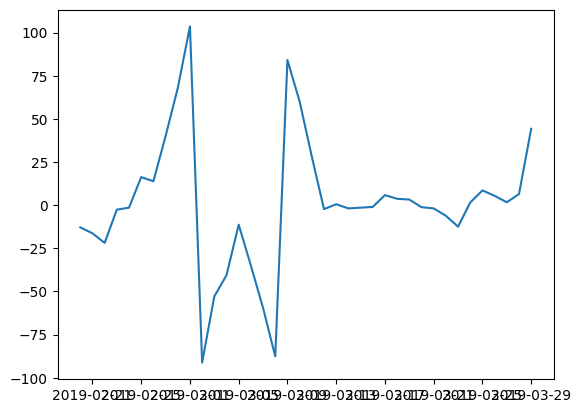

In [60]:
plt.plot(new_data_without_trend.diff(7))

plt.show()

In [61]:
kpss(new_data_without_trend['Time'].diff(7)[7:], nlags='legacy')

<ipython-input-61-1afcd861176b>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(new_data_without_trend['Time'].diff(7)[7:], nlags='legacy')


(0.1991989922662678,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


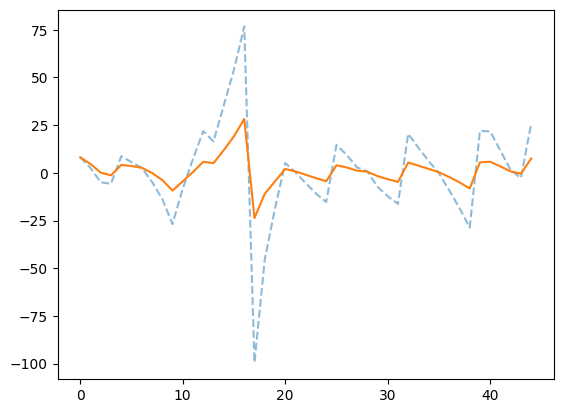

In [73]:
arima = ARIMA(new_data_without_trend['Time'].values, order=(1,1,1)).fit()

plt.plot(new_data_without_trend['Time'].values, alpha=0.5, ls='--')
plt.plot(arima.predict(1, len(new_data_without_trend), dynamic=False))

plt.show()

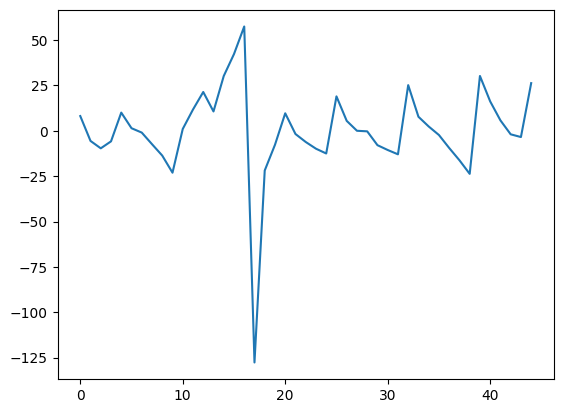

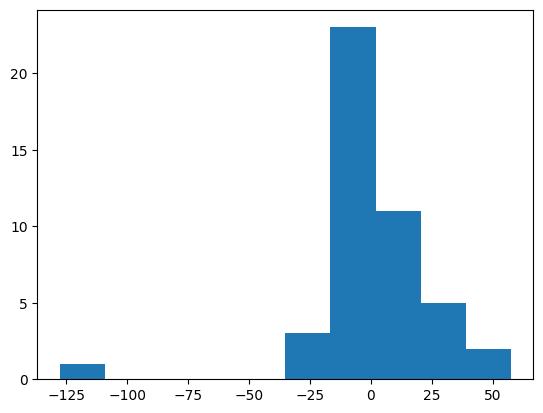

ShapiroResult(statistic=0.7635684013366699, pvalue=4.1134316575153207e-07)

In [75]:
_ =plt.plot(arima.resid)
plt.show()
_ = plt.hist(arima.resid)
plt.show()
st.shapiro(arima.resid)

In [76]:
arima = SARIMAX(new_data_without_trend['Time'].values, order=(1,0,1), seasonal_order=(0,2,1,7)).fit()

arima.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   45
Model:             SARIMAX(1, 0, 1)x(0, 2, 1, 7)   Log Likelihood                -166.036
Date:                           Fri, 19 Apr 2024   AIC                            340.072
Time:                                   15:55:32   BIC                            345.808
Sample:                                        0   HQIC                           341.942
                                            - 45                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8273      0.725      1.141      0.254      -0.594       2.248
ma.L1         -0.9987     66.784     -0.015      0.988    -131.894     129.896
ma.S.L7       -0.9991    289.956     -0.003      0.997    -569.302     567.304
sigma2      1659.3860   4.59e+05      0.004      0.997   -8.99e+05    9.02e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.55   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.06   Prob(JB):                         0.41
Heteroskedasticity (H):               0.06   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

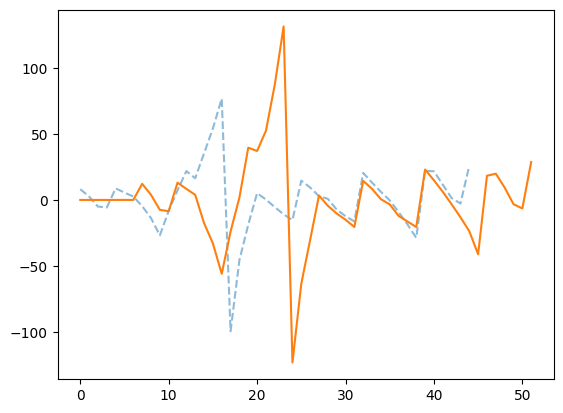

In [77]:
plt.plot(new_data_without_trend['Time'].values, alpha=0.5, ls='--')
plt.plot(arima.predict(0, len(new_data['Time'].values)))

plt.show()

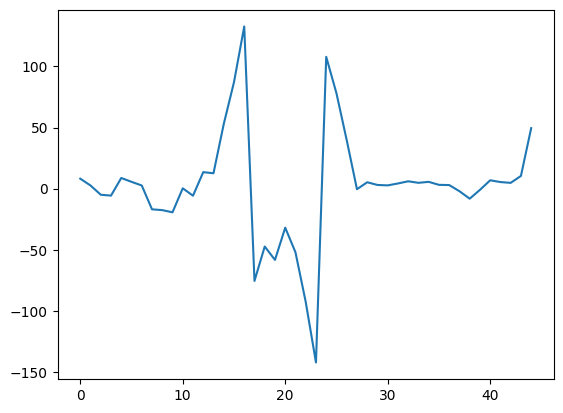

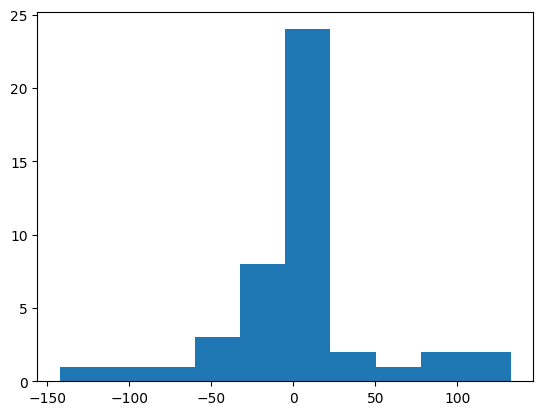

ShapiroResult(statistic=0.8718152642250061, pvalue=0.00014036131324246526)

In [78]:
_ =plt.plot(arima.resid)
plt.show()
_ = plt.hist(arima.resid)
plt.show()
st.shapiro(arima.resid)


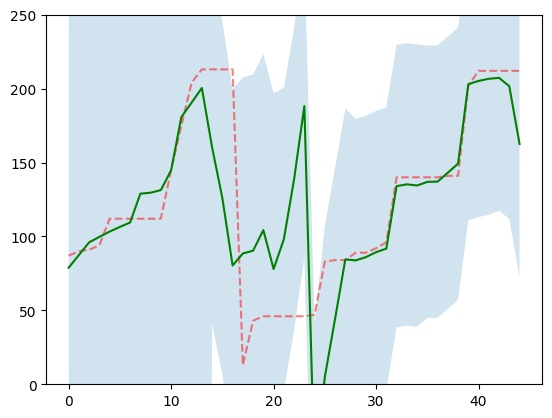

In [85]:
predictition = arima.get_prediction(0, len(new_data_without_trend)-1).conf_int()
intervals = stl_data.trend.values.flatten()[3:-3] + predictition[:, 0], stl_data.trend.values.flatten()[3:-3] + predictition[:, 1]

plt.fill_between(range(len(intervals[0])), intervals[0], intervals[1], alpha=0.2)
plt.ylim(0, 250)
plt.plot(new_data['Time'].values[3:-3], alpha=0.5, ls='--', c='r')
plt.plot(stl_data.trend.values.flatten()[3:-3]+arima.predict(0, len(new_data_without_trend)-1), c='g')

plt.show()

### ETS

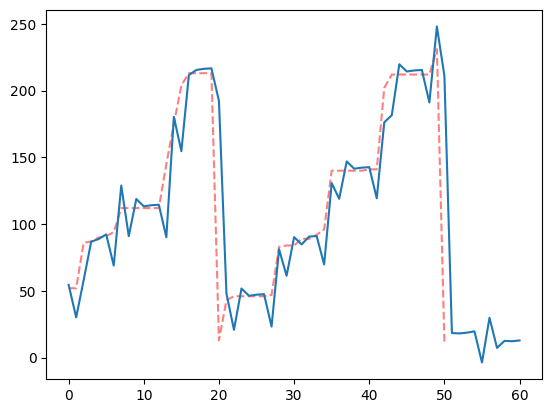

In [87]:
ets = ExponentialSmoothing(new_data['Time'].values, trend='add', seasonal='add', seasonal_periods=7).fit()
plt.plot(new_data['Time'].values, alpha=0.5, ls='--', c='r')
predicted = ets.predict(0, 60)

plt.plot(predicted)

plt.show()

## Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие два года.

In [ ]:
data = pd.read_csv('data/monthly-australian-wine-sales-th.csv', parse_dates=[0], delimiter=',')
data.head()

In [ ]:
data.columns = ['date', 'wine']
data.head()

In [ ]:
sns.lineplot(data['date'],data['wine'])

plt.show()

Попробуем поделить на число дней в месяце:

In [ ]:
values = data['wine'].values.copy()
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for i in range(len(values)):
    values[i]/=days[i%12]
sns.lineplot(data['date'],values)

plt.show()

Ряд не стал более регулярным, так что вернёмся к исходным данным.

STL-декомпозиция ряда:

In [ ]:
data = data.set_index(pd.DatetimeIndex(data['date']))

In [ ]:
data.head()

In [ ]:
stl_data = seasonal_decompose(data['wine'])
_= stl_data.plot()

In [ ]:
transformed, lam = st.boxcox(data['wine'])
data['bc'] = transformed
print (lam)
stl_data = seasonal_decompose(transformed, period=12)
_= stl_data.plot()

### ARIMA

Стационарность:

In [ ]:
kpss(data['wine'], nlags='legacy')

Cделаем сезонное дифференцирование:

In [ ]:
diff_ts = data['wine'].diff(12)[12:]
plt.plot(diff_ts)
kpss(diff_ts, nlags='legacy')

Ряд всё ещё нестационарен. Проведём ещё одно дифференцирование:

In [ ]:
diff_diff_ts = diff_ts.diff(1)[1:]
plt.plot(diff_diff_ts)
kpss(diff_diff_ts, nlags='legacy')


Для полученного ряда гипотеза стационарности не отвергается

Посмотрим на ACF и PACF полученного продифференцированного ряда:

In [ ]:
plot_acf(diff_diff_ts, lags=15)

plt.show()

In [ ]:
plot_pacf(diff_diff_ts, lags=15)

plt.show()

На ACF значимы лаги 1 и 12, на PACF — 1-3. Будем искать модель, оптимальную по AICc, в окрестности ARIMA(3,1,1)

In [ ]:
for i in range(-1,2):
    for k in range(-1, 2):
        order = (3+i,1,1+k)
        try:
            arima = ARIMA(data['wine'].values, order=order).fit()
            print(arima.summary())
        except:
            pass

In [ ]:
arima = ARIMA(data['wine'].values, order=(2,1,1)).fit()
print(arima.summary())

In [ ]:
plt.plot(arima.resid)
plot_pacf(arima.resid, lags=15)
plot_acf(arima.resid, lags=15)

plt.show()

In [ ]:
for i in range(-1,2):
    for j in range(-1, 2):
        order = (3+i, 1, 1+j)
        sorder = (1, 1, 1, 12)
        try:
            arima = SARIMAX(data['wine'].values, order=order, seasonal_order=sorder).fit()
            print(arima.summary())
        except:
            pass

In [ ]:
arima = SARIMAX(data['wine'].values, order=(2,1,1), seasonal_order=(1, 1, 1, 12)).fit()


plt.plot(arima.resid)
plot_pacf(arima.resid, lags=15)
plot_acf(arima.resid, lags=15)

plt.show()

In [ ]:
plt.scatter(range(16), acorr_ljungbox(arima.resid, lags=16)[1])

plt.show()

Q-Q plot:

In [ ]:
_ = st.probplot(arima.resid, plot=plt)
print (st.shapiro(arima.resid))
plt.show()
plt.hist(arima.resid)

plt.show()

In [ ]:
arima = SARIMAX(data['wine'].values[:-12], order=(3,1,1), seasonal_order=(1,1,1,12)).fit()
predicted = arima.predict(0, data.shape[0])

In [ ]:
plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [ ]:
arima = SARIMAX(data['wine'].values[:-12], order=(3,1,1), seasonal_order=(1,1,1,12)).fit()
predicted = arima.predict(data.shape[0]-12, data.shape[0]-1, dynamic=True)

In [ ]:
plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), predicted)

plt.show()

### ETS

In [ ]:
ets = ExponentialSmoothing(data['wine'].values[12:]).fit(optimized=True)

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [ ]:
ets = ExponentialSmoothing(data['wine'].values[12:],  trend='add').fit()

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [ ]:
ets = ExponentialSmoothing(data['wine'].values[12:], seasonal='mul', trend='add', seasonal_periods=12).fit()

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [ ]:
_ = st.probplot(ets.resid, plot=plt)
print (st.shapiro(ets.resid))
plt.show()

plt.hist(ets.resid)
plt.show()

In [ ]:
ets = ExponentialSmoothing(data['wine'].values[12:], seasonal='mul', trend='add', seasonal_periods=12).fit(use_boxcox=True)

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [ ]:
_ = st.probplot(ets.resid, plot=plt)
print (st.shapiro(ets.resid))
plt.show()

plt.hist(ets.resid)
plt.show()

In [ ]:
ets = ExponentialSmoothing(data['bc'].values[12:], seasonal='mul', trend='add', seasonal_periods=12).fit()

predicted = ets.predict(0, data.shape[0])

plt.plot(data['bc'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['bc'].values[:-12]), len(data['bc'])), data['bc'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [ ]:
_ = st.probplot(ets.resid, plot=plt)
print (st.shapiro(ets.resid))
plt.show()

plt.hist(ets.resid)
plt.show()